# Laboratorio 11 - Visualizaciones y Segmentación
## Análisis Avanzado de Churn
- Nelson García Bravatti
- Christian Echeverría

Este notebook complementa el análisis principal con visualizaciones detalladas y segmentación de clientes.

In [51]:
!pip -q install pyspark matplotlib seaborn plotly scikit-learn

In [52]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.ml.clustering import KMeans

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

spark = SparkSession.builder.appName("Lab11_Visualizaciones").getOrCreate()
print("✅ Spark version:", spark.version)

✅ Spark version: 3.5.1


---
## 1. Carga y Preparación de Datos

In [53]:
# Cargar datos
df = spark.read.option("header", True).option("inferSchema", True).csv('abandono_clientes.csv')

# Ingeniería de features
anchor_date = df.agg(F.max("Onboard_date").alias("maxd")).collect()[0]["maxd"]

df_feat = (
    df
    .withColumn(
        "Tenure_from_onboard",
        (F.datediff(F.lit(anchor_date), F.col("Onboard_date"))/F.lit(365.25)).cast("double")
    )
    .withColumn("Sites_per_Year",
               (F.col("Num_Sites")/(F.col("Years")+F.lit(1e-6))).cast("double"))
    .withColumn("Purchase_per_Site",
               (F.col("Total_Purchase")/(F.col("Num_Sites")+F.lit(1e-6))).cast("double"))
    .withColumn("Purchase_per_Year",
               (F.col("Total_Purchase")/(F.col("Years")+F.lit(1e-6))).cast("double"))
)

print(f"✅ Dataset cargado: {df_feat.count()} filas")

# Convertir a Pandas para visualizaciones
df_pd = df_feat.toPandas()
print(f"✅ Datos convertidos a Pandas para visualización")

✅ Dataset cargado: 900 filas
✅ Datos convertidos a Pandas para visualización


---
## 2. Visualizaciones Exploratorias

### 2.1 Distribución de Variables por Clase

✅ Gráfico guardado: distribuciones_por_clase.png


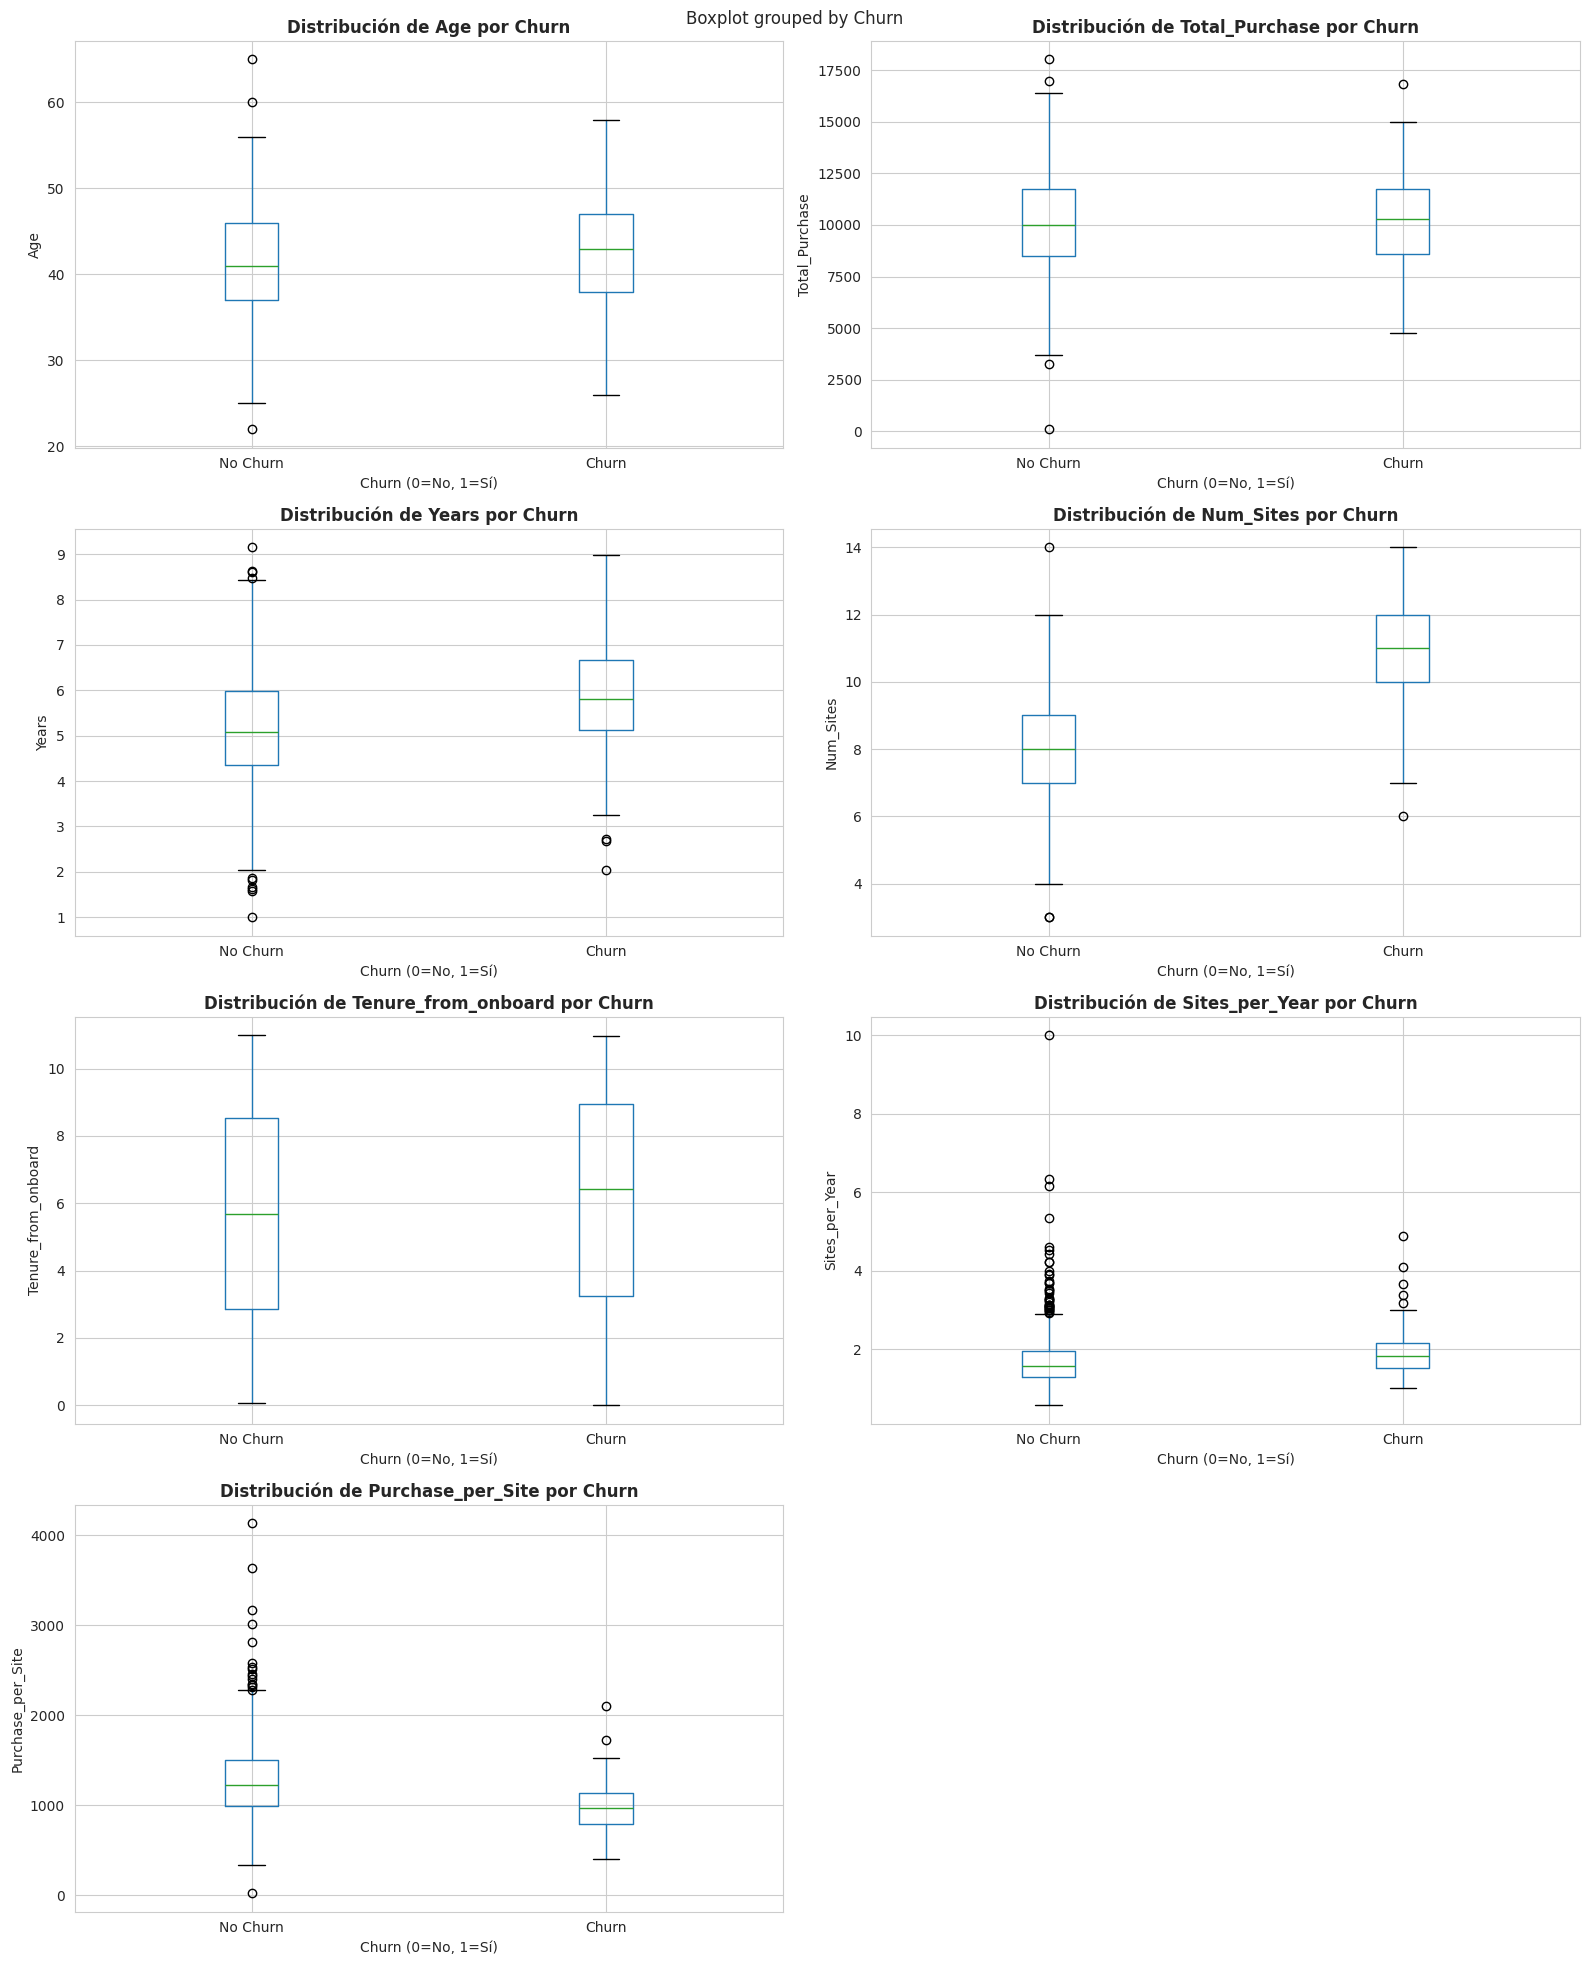

In [54]:
# Variables numéricas a visualizar
numeric_vars = ['Age', 'Total_Purchase', 'Years', 'Num_Sites',
                'Tenure_from_onboard', 'Sites_per_Year', 'Purchase_per_Site']

# Crear subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for idx, var in enumerate(numeric_vars):
    ax = axes[idx]

    # Boxplot por clase
    df_pd.boxplot(column=var, by='Churn', ax=ax)
    ax.set_title(f'Distribución de {var} por Churn', fontsize=12, fontweight='bold')
    ax.set_xlabel('Churn (0=No, 1=Sí)', fontsize=10)
    ax.set_ylabel(var, fontsize=10)
    plt.sca(ax)
    plt.xticks([1, 2], ['No Churn', 'Churn'])

# Remover subplot extra
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('distribuciones_por_clase.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: distribuciones_por_clase.png")
plt.show()

### 2.2 Violin Plots (Densidad de Distribuciones)

/tmp/ipython-input-2106021199.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2106021199.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-2106021199.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2106021199.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-2106021199.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tm

✅ Gráfico guardado: violin_plots.png


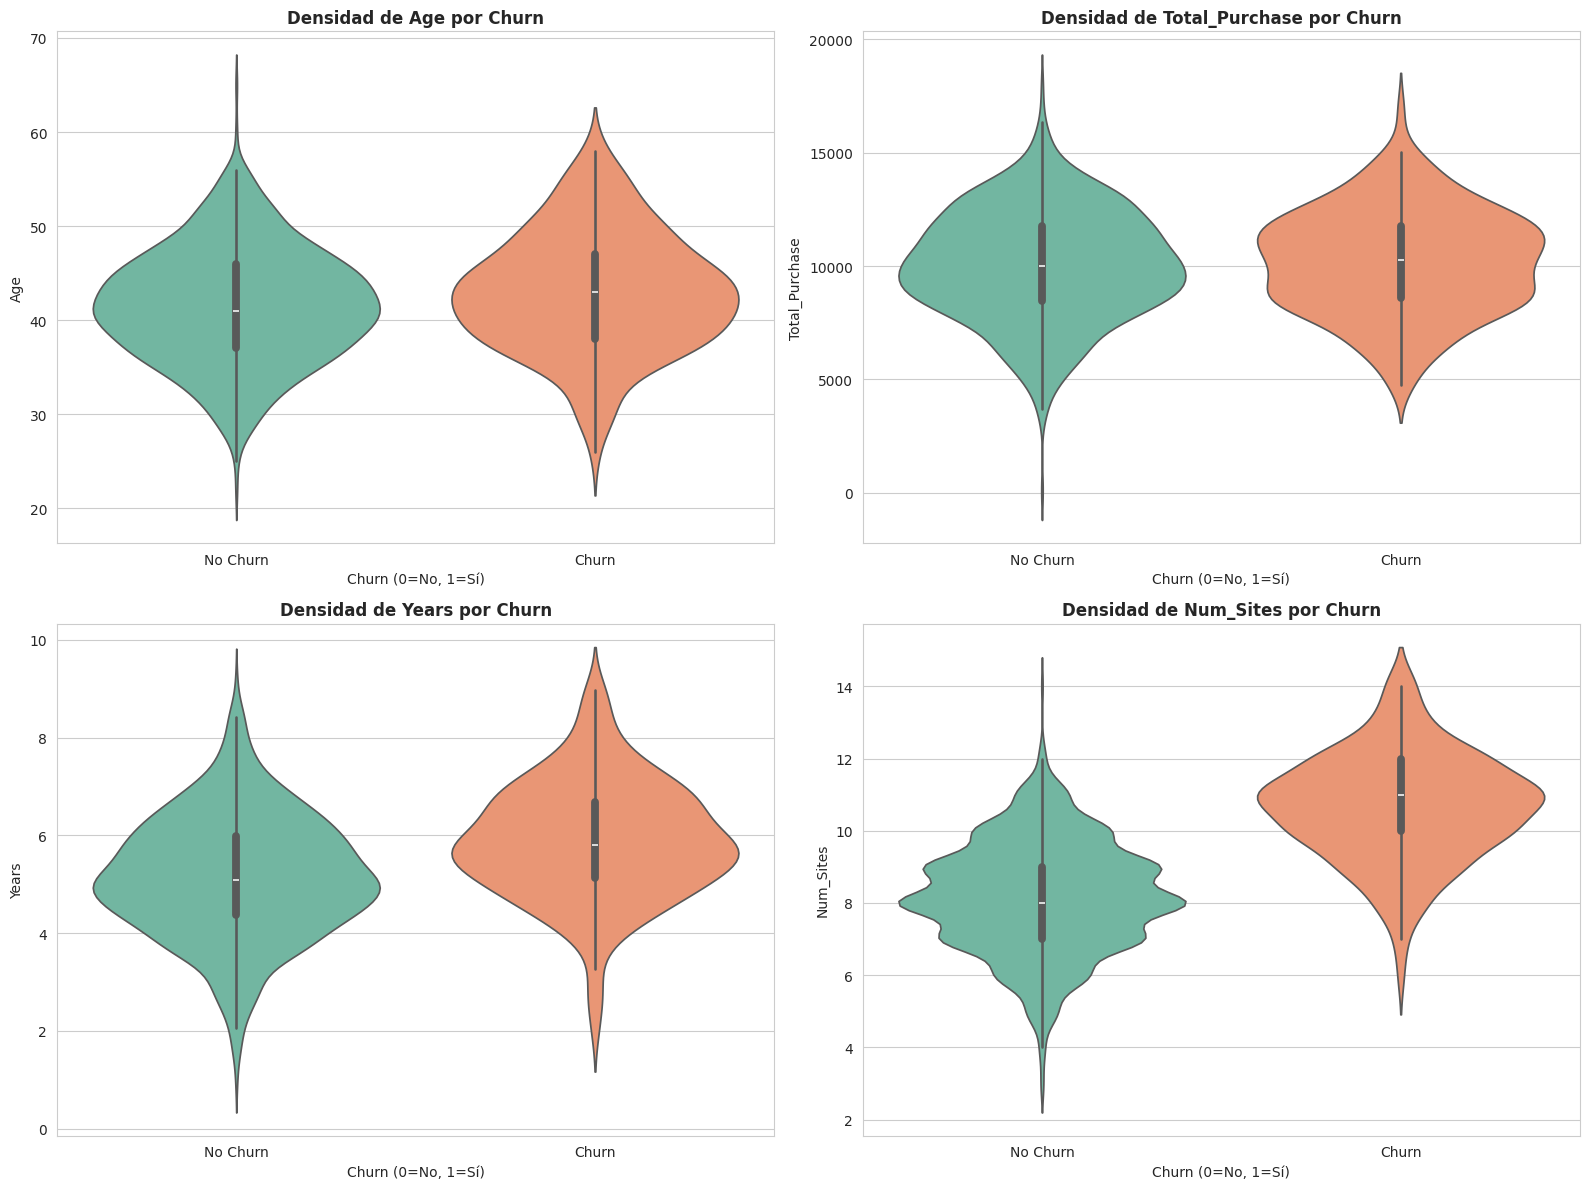

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

key_vars = ['Age', 'Total_Purchase', 'Years', 'Num_Sites']

for idx, var in enumerate(key_vars):
    ax = axes[idx]

    sns.violinplot(data=df_pd, x='Churn', y=var, ax=ax, palette='Set2')
    ax.set_title(f'Densidad de {var} por Churn', fontsize=12, fontweight='bold')
    ax.set_xlabel('Churn (0=No, 1=Sí)', fontsize=10)
    ax.set_xticklabels(['No Churn', 'Churn'])

plt.tight_layout()
plt.savefig('violin_plots.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: violin_plots.png")
plt.show()

### 2.3 Matriz de Correlación (Heatmap)

✅ Gráfico guardado: correlation_matrix.png


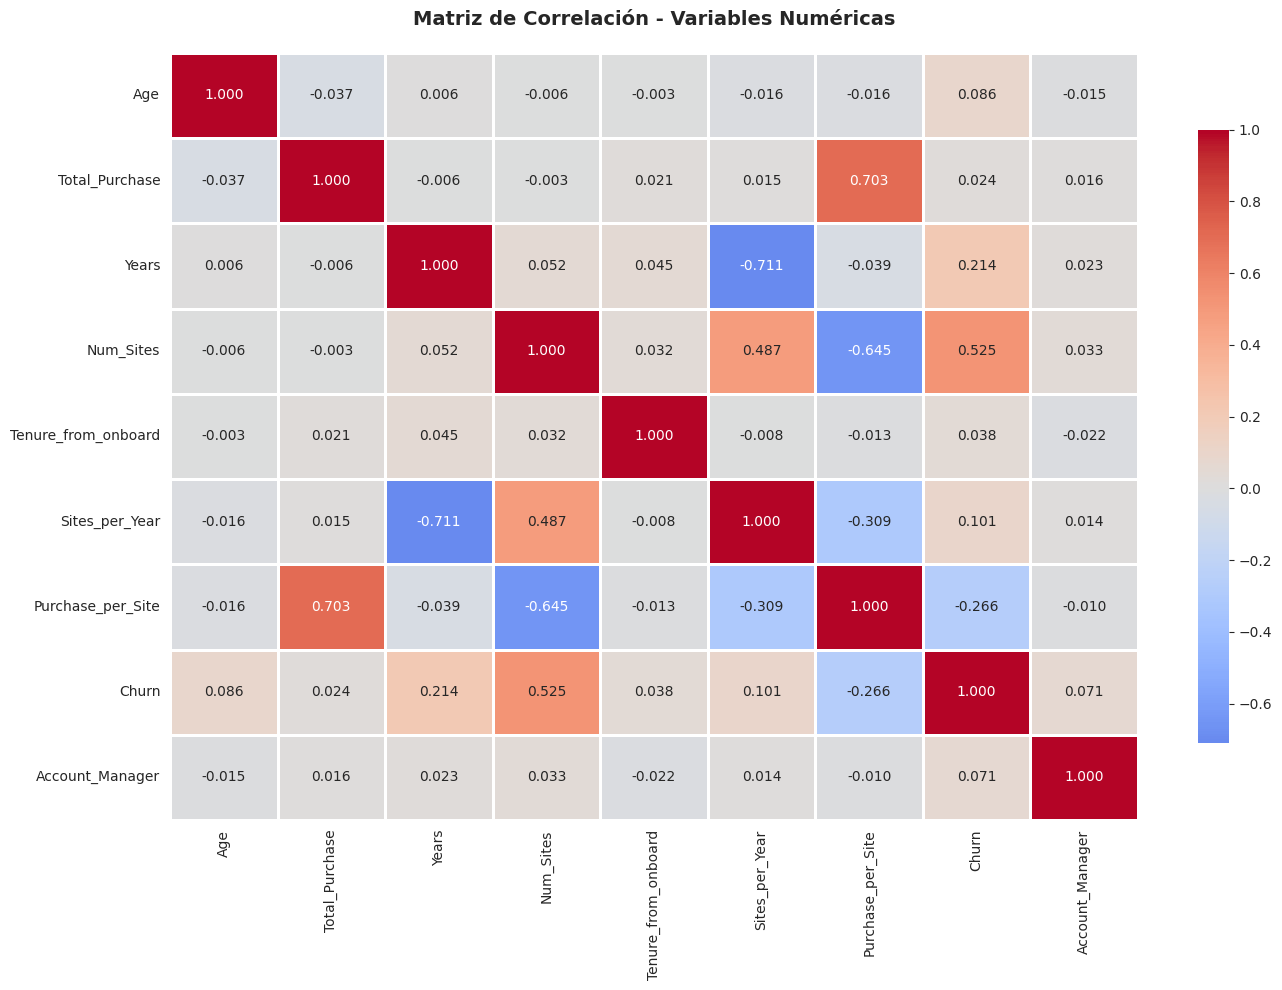


📊 Correlaciones con Churn (ordenadas por magnitud):
Num_Sites                  0.5254
Purchase_per_Site         -0.2658
Years                      0.2143
Sites_per_Year             0.1013
Age                        0.0859
Account_Manager            0.0706
Tenure_from_onboard        0.0381
Total_Purchase             0.0240


In [56]:
# Matriz de correlación
corr_vars = numeric_vars + ['Churn', 'Account_Manager']
corr_matrix = df_pd[corr_vars].corr()

# Crear heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: correlation_matrix.png")
plt.show()

# Correlaciones con Churn ordenadas
print("\n📊 Correlaciones con Churn (ordenadas por magnitud):")
print("="*50)
churn_corr = corr_matrix['Churn'].drop('Churn').abs().sort_values(ascending=False)
for var, corr in churn_corr.items():
    sign = corr_matrix.loc[var, 'Churn']
    print(f"{var:<25} {sign:>7.4f}")

### 2.4 Pairplot - Relaciones Bivariadas

✅ Gráfico guardado: pairplot.png


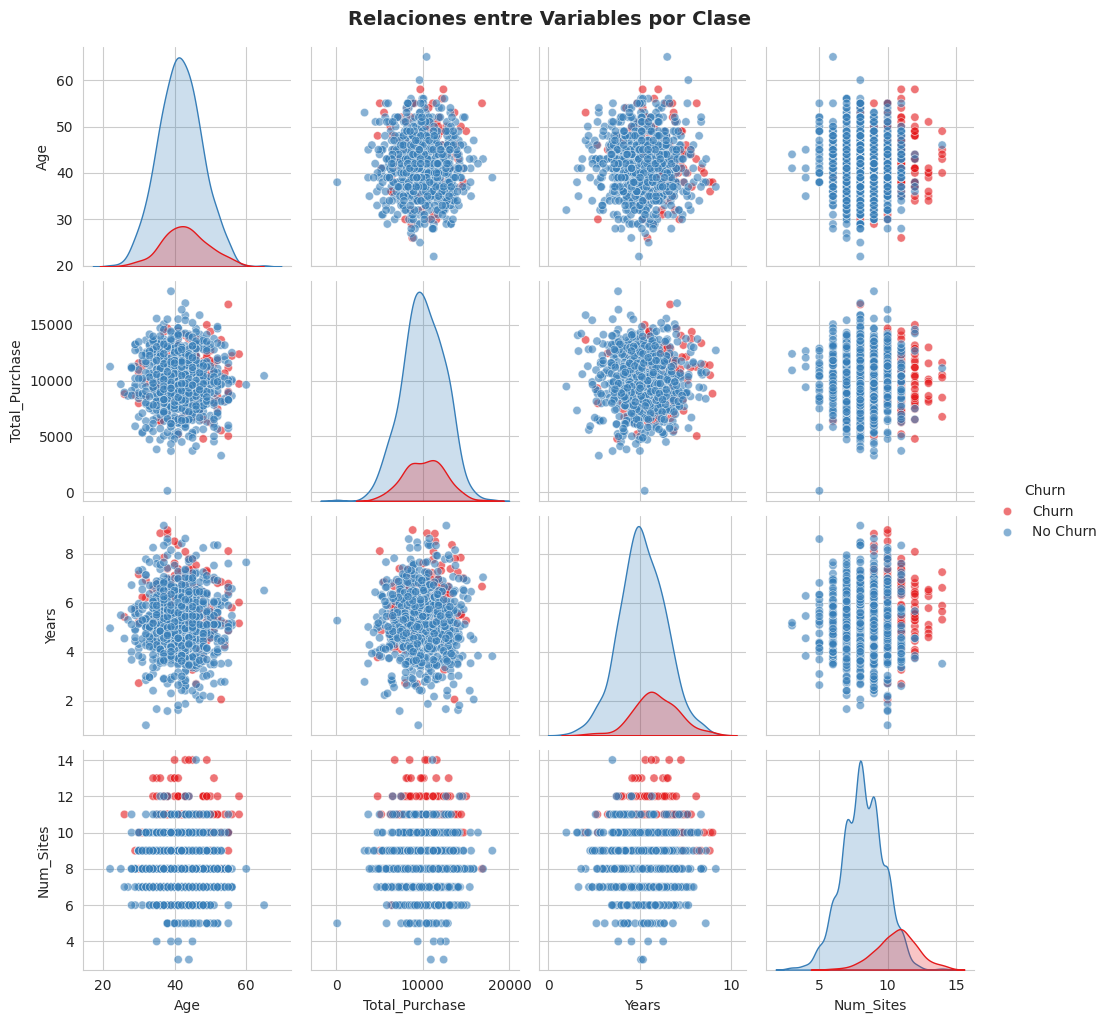

In [57]:
# Seleccionar variables clave para pairplot
key_features = ['Age', 'Total_Purchase', 'Years', 'Num_Sites', 'Churn']
df_pair = df_pd[key_features].copy()
df_pair['Churn'] = df_pair['Churn'].map({0: 'No Churn', 1: 'Churn'})

# Crear pairplot
pairplot = sns.pairplot(df_pair, hue='Churn', palette='Set1',
                        diag_kind='kde', plot_kws={'alpha': 0.6})
pairplot.fig.suptitle('Relaciones entre Variables por Clase', y=1.02, fontsize=14, fontweight='bold')
plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: pairplot.png")
plt.show()

### 2.5 Análisis de Account Manager

✅ Gráfico guardado: account_manager_analysis.png


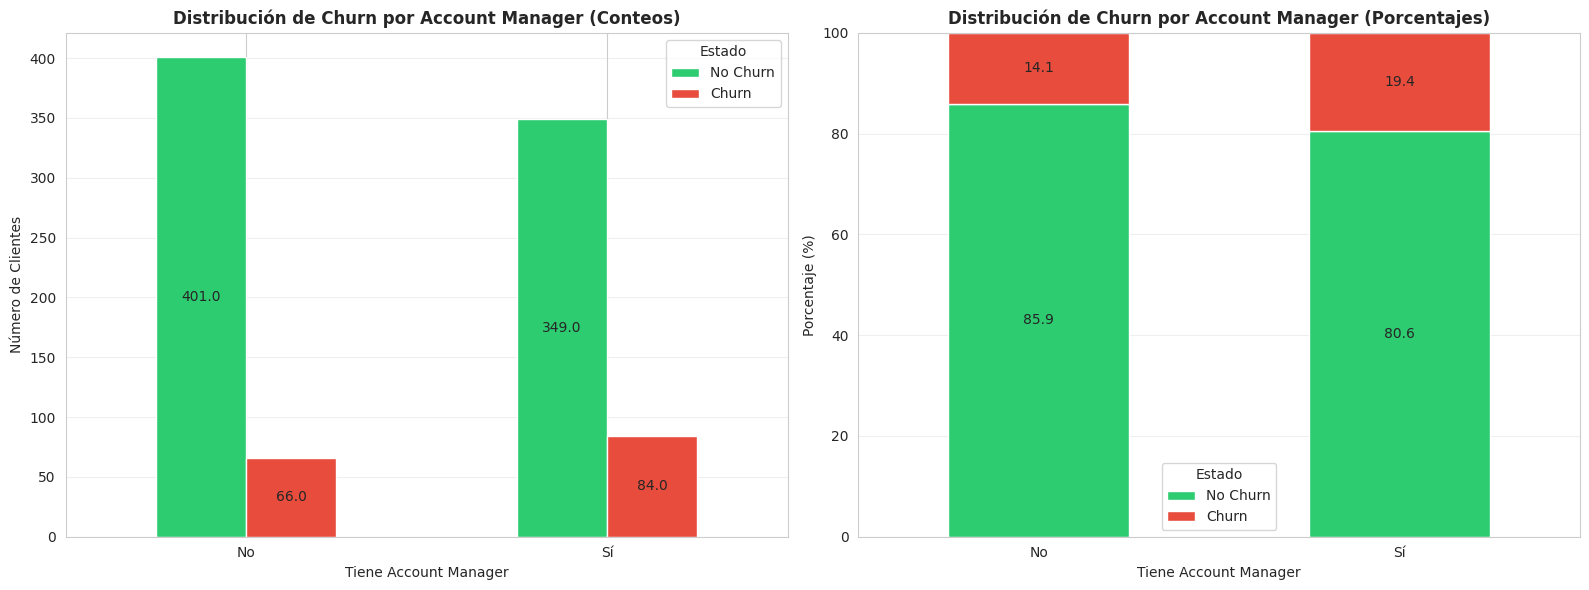


📊 Tasa de Churn por Account Manager:
SIN Account Manager: 14.13%
CON Account Manager: 19.40%


In [58]:
# Crear tabla de contingencia
ct_data = df_pd.groupby(['Account_Manager', 'Churn']).size().unstack(fill_value=0)
ct_data_pct = ct_data.div(ct_data.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Conteos absolutos
ct_data.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribución de Churn por Account Manager (Conteos)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Tiene Account Manager', fontsize=10)
axes[0].set_ylabel('Número de Clientes', fontsize=10)
axes[0].set_xticklabels(['No', 'Sí'], rotation=0)
axes[0].legend(['No Churn', 'Churn'], title='Estado')
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Porcentajes
ct_data_pct.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'], stacked=True)
axes[1].set_title('Distribución de Churn por Account Manager (Porcentajes)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tiene Account Manager', fontsize=10)
axes[1].set_ylabel('Porcentaje (%)', fontsize=10)
axes[1].set_xticklabels(['No', 'Sí'], rotation=0)
axes[1].legend(['No Churn', 'Churn'], title='Estado')
axes[1].set_ylim([0, 100])
axes[1].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', label_type='center')

plt.tight_layout()
plt.savefig('account_manager_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: account_manager_analysis.png")
plt.show()

print("\n📊 Tasa de Churn por Account Manager:")
print("="*50)
churn_rate = df_pd.groupby('Account_Manager')['Churn'].mean() * 100
print(f"SIN Account Manager: {churn_rate[0]:.2f}%")
print(f"CON Account Manager: {churn_rate[1]:.2f}%")

  ---
## 3. Ingeniería de Características

Creamos variables derivadas que pueden ser predictivas del churn:

In [59]:
# Fecha ancla para calcular tenure
anchor_date = df.agg(F.max("Onboard_date").alias("maxd")).collect()[0]["maxd"]
print(f"\n📅 Fecha ancla para tenure: {anchor_date}")

# Función para crear features
def create_features(data):
    return (
        data
        .withColumn(
            "Tenure_from_onboard",
            (F.datediff(F.lit(anchor_date), F.col("Onboard_date"))/F.lit(365.25)).cast("double")
        )
        .withColumn("Sites_per_Year",
                   (F.col("Num_Sites")/(F.col("Years")+F.lit(1e-6))).cast("double"))
        .withColumn("Purchase_per_Site",
                   (F.col("Total_Purchase")/(F.col("Num_Sites")+F.lit(1e-6))).cast("double"))
        .withColumn("Purchase_per_Year",
                   (F.col("Total_Purchase")/(F.col("Years")+F.lit(1e-6))).cast("double"))
    )

df_feat = create_features(df)

print("\n✅ FEATURES CREADAS:")
print("   1. Tenure_from_onboard: Años desde onboarding")
print("   2. Sites_per_Year: Sitios por año de relación")
print("   3. Purchase_per_Site: Inversión por sitio")
print("   4. Purchase_per_Year: Inversión anual")

print("\n📋 EJEMPLO DE DATOS CON NUEVAS FEATURES:")
df_feat.select(
    "Names", "Years", "Num_Sites", "Total_Purchase",
    "Tenure_from_onboard", "Sites_per_Year", "Purchase_per_Site", "Churn"
).show(5, truncate=False)


📅 Fecha ancla para tenure: 2016-12-28 04:07:38

✅ FEATURES CREADAS:
   1. Tenure_from_onboard: Años desde onboarding
   2. Sites_per_Year: Sitios por año de relación
   3. Purchase_per_Site: Inversión por sitio
   4. Purchase_per_Year: Inversión anual

📋 EJEMPLO DE DATOS CON NUEVAS FEATURES:
+----------------+-----+---------+--------------+-------------------+------------------+------------------+-----+
|Names           |Years|Num_Sites|Total_Purchase|Tenure_from_onboard|Sites_per_Year    |Purchase_per_Site |Churn|
+----------------+-----+---------+--------------+-------------------+------------------+------------------+-----+
|Cameron Williams|7.22 |8.0      |11066.8       |3.3292265571526354 |1.1080330875300433|1383.3498270812715|1    |
|Kevin Mueller   |6.5  |11.0     |11916.22      |3.375770020533881  |1.6923074319527027|1083.2926287915793|1    |
|Eric Lozano     |6.67 |12.0     |12884.75      |0.49828884325804246|1.7991001800449504|1073.7290771892435|1    |
|Phillip White   |6.71

---
## 4. Preparación de Datos para Modelado

### 4.1 División Train/Test Estratificada

In [60]:
# Split estratificado 70/30 por clase
pos = df_feat.filter(F.col("Churn") == 1).withColumn("rand", F.rand(seed=42))
neg = df_feat.filter(F.col("Churn") == 0).withColumn("rand", F.rand(seed=42))

train = pos.filter("rand <= 0.7").unionByName(neg.filter("rand <= 0.7")).drop("rand")
test  = pos.filter("rand > 0.7").unionByName(neg.filter("rand > 0.7")).drop("rand")

print(f"\n📊 DIVISIÓN DE DATOS (70/30 ESTRATIFICADA)")
print(f"{'='*60}")
print(f"Train: {train.count()} filas")
print(f"Test:  {test.count()} filas")

print("\n🔹 Distribución en TRAIN:")
train.groupBy("Churn").count().withColumn(
    "prop_%", F.round(F.col("count")/train.count()*100, 2)
).show()

print("🔹 Distribución en TEST:")
test.groupBy("Churn").count().withColumn(
    "prop_%", F.round(F.col("count")/test.count()*100, 2)
).show()


📊 DIVISIÓN DE DATOS (70/30 ESTRATIFICADA)
Train: 659 filas
Test:  241 filas

🔹 Distribución en TRAIN:
+-----+-----+------+
|Churn|count|prop_%|
+-----+-----+------+
|    1|  104| 15.78|
|    0|  555| 84.22|
+-----+-----+------+

🔹 Distribución en TEST:
+-----+-----+------+
|Churn|count|prop_%|
+-----+-----+------+
|    1|   46| 19.09|
|    0|  195| 80.91|
+-----+-----+------+



### 4.2 Cálculo de Pesos de Clase

In [61]:
# Calcular pesos para balancear clases
n_train = train.count()
n_pos = train.filter(F.col("Churn") == 1).count()
n_neg = n_train - n_pos
pos_weight = n_neg / float(n_pos)

print(f"\n⚖️ PESOS DE CLASE")
print(f"{'='*60}")
print(f"Clientes sin churn (clase 0): peso = 1.0")
print(f"Clientes con churn (clase 1): peso = {pos_weight:.2f}")
print(f"\n💡 La clase positiva tiene {pos_weight:.1f}x más peso para compensar desbalance")

# Añadir columna de pesos
train_w = train.withColumn(
    "classWeightCol",
    F.when(F.col("Churn") == 1, F.lit(pos_weight)).otherwise(F.lit(1.0))
)


⚖️ PESOS DE CLASE
Clientes sin churn (clase 0): peso = 1.0
Clientes con churn (clase 1): peso = 5.34

💡 La clase positiva tiene 5.3x más peso para compensar desbalance


### 4.3 Definición de Features para Modelado

In [62]:
# Features finales
features = [
    "Age", "Total_Purchase", "Years", "Num_Sites",
    "Tenure_from_onboard", "Sites_per_Year", "Purchase_per_Site", "Purchase_per_Year"
]

print(f"\n🎯 FEATURES PARA MODELADO ({len(features)} variables):")
print(f"{'='*60}")
for i, feat in enumerate(features, 1):
    print(f"   {i}. {feat}")

# Crear assembler
assembler = VectorAssembler(inputCols=features, outputCol="features", handleInvalid="skip")
print("\n✅ VectorAssembler configurado")


🎯 FEATURES PARA MODELADO (8 variables):
   1. Age
   2. Total_Purchase
   3. Years
   4. Num_Sites
   5. Tenure_from_onboard
   6. Sites_per_Year
   7. Purchase_per_Site
   8. Purchase_per_Year

✅ VectorAssembler configurado


---
## 5. Entrenamiento de Modelos

### 5.1 Regresión Logística con Grid Search

In [63]:
print("\n🤖 ENTRENANDO MODELO: REGRESIÓN LOGÍSTICA")
print(f"{'='*60}")

# Definir modelo
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Churn",
    weightCol="classWeightCol",
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    maxIter=200
)

# Grid de hiperparámetros
paramGrid_lr = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.0, 0.01, 0.1, 0.5])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # Ridge, Elastic Net, Lasso
    .build()
)

print(f"\n🔍 Grid Search: {len(paramGrid_lr)} combinaciones de hiperparámetros")

# Evaluadores
evaluator_pr = BinaryClassificationEvaluator(
    labelCol="Churn", rawPredictionCol="rawPrediction", metricName="areaUnderPR"
)
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="Churn", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)

# Pipeline y validación
pipeline_lr = Pipeline(stages=[assembler, lr])

tvs_lr = TrainValidationSplit(
    estimator=pipeline_lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator_pr,
    trainRatio=0.8,
    parallelism=2
)

# Entrenar
print("\n⏳ Entrenando modelo... (esto puede tomar 1-2 minutos)")
model_lr = tvs_lr.fit(train_w)
preds_lr = model_lr.transform(test)

# Evaluar
auc_pr_lr  = evaluator_pr.evaluate(preds_lr)
auc_roc_lr = evaluator_roc.evaluate(preds_lr)

print(f"\n✅ RESULTADOS - REGRESIÓN LOGÍSTICA")
print(f"{'='*60}")
print(f"PR-AUC:  {auc_pr_lr:.4f}")
print(f"ROC-AUC: {auc_roc_lr:.4f}")


🤖 ENTRENANDO MODELO: REGRESIÓN LOGÍSTICA

🔍 Grid Search: 12 combinaciones de hiperparámetros

⏳ Entrenando modelo... (esto puede tomar 1-2 minutos)

✅ RESULTADOS - REGRESIÓN LOGÍSTICA
PR-AUC:  0.8056
ROC-AUC: 0.9212


### 5.2 Random Forest (Modelo Alternativo)

In [64]:
print("\n🌲 ENTRENANDO MODELO: RANDOM FOREST")
print(f"{'='*60}")

# Definir modelo
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="Churn",
    weightCol="classWeightCol",
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    seed=42
)

# Grid (más limitado por tiempo de ejecución)
paramGrid_rf = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])
    .addGrid(rf.maxDepth, [5, 10])
    .addGrid(rf.minInstancesPerNode, [1, 5])
    .build()
)

print(f"\n🔍 Grid Search: {len(paramGrid_rf)} combinaciones")

# Pipeline
pipeline_rf = Pipeline(stages=[assembler, rf])

tvs_rf = TrainValidationSplit(
    estimator=pipeline_rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator_pr,
    trainRatio=0.8,
    parallelism=2
)

# Entrenar
print("\n⏳ Entrenando... (puede tomar 3-5 minutos)")
model_rf = tvs_rf.fit(train_w)
preds_rf = model_rf.transform(test)

# Evaluar
auc_pr_rf  = evaluator_pr.evaluate(preds_rf)
auc_roc_rf = evaluator_roc.evaluate(preds_rf)

print(f"\n✅ RESULTADOS - RANDOM FOREST")
print(f"{'='*60}")
print(f"PR-AUC:  {auc_pr_rf:.4f}")
print(f"ROC-AUC: {auc_roc_rf:.4f}")


🌲 ENTRENANDO MODELO: RANDOM FOREST

🔍 Grid Search: 8 combinaciones

⏳ Entrenando... (puede tomar 3-5 minutos)

✅ RESULTADOS - RANDOM FOREST
PR-AUC:  0.7691
ROC-AUC: 0.9040


### 5.3 Comparación y Selección del Mejor Modelo

In [65]:
print("\n📊 COMPARACIÓN DE MODELOS")
print(f"{'='*70}")
print(f"{'Modelo':<25} {'PR-AUC':>15} {'ROC-AUC':>15}")
print(f"{'-'*70}")
print(f"{'Regresión Logística':<25} {auc_pr_lr:>15.4f} {auc_roc_lr:>15.4f}")
print(f"{'Random Forest':<25} {auc_pr_rf:>15.4f} {auc_roc_rf:>15.4f}")
print(f"{'-'*70}")

# Seleccionar mejor modelo
if auc_pr_lr >= auc_pr_rf:
    best_model = model_lr
    best_preds = preds_lr
    best_name = "Regresión Logística"
    best_auc_pr = auc_pr_lr
    best_auc_roc = auc_roc_lr
else:
    best_model = model_rf
    best_preds = preds_rf
    best_name = "Random Forest"
    best_auc_pr = auc_pr_rf
    best_auc_roc = auc_roc_rf

print(f"\n🏆 MEJOR MODELO: {best_name}")
print(f"   PR-AUC:  {best_auc_pr:.4f}")
print(f"   ROC-AUC: {best_auc_roc:.4f}")


📊 COMPARACIÓN DE MODELOS
Modelo                             PR-AUC         ROC-AUC
----------------------------------------------------------------------
Regresión Logística                0.8056          0.9212
Random Forest                      0.7691          0.9040
----------------------------------------------------------------------

🏆 MEJOR MODELO: Regresión Logística
   PR-AUC:  0.8056
   ROC-AUC: 0.9212


---
## 6. Optimización del Umbral de Decisión

In [66]:
# Extraer probabilidades
preds_with_prob = best_preds.withColumn("prob_churn", vector_to_array("probability").getItem(1))

def metrics_at_threshold(pred_df, thr, prob_col="prob_churn", label_col="Churn"):
    """Calcula métricas para un umbral dado"""
    scored = pred_df.withColumn("yhat", (F.col(prob_col) >= F.lit(thr)).cast("int"))
    agg = (scored
           .groupBy()
           .agg(
               F.sum(F.when((F.col(label_col)==1) & (F.col("yhat")==1), 1).otherwise(0)).alias("TP"),
               F.sum(F.when((F.col(label_col)==0) & (F.col("yhat")==1), 1).otherwise(0)).alias("FP"),
               F.sum(F.when((F.col(label_col)==0) & (F.col("yhat")==0), 1).otherwise(0)).alias("TN"),
               F.sum(F.when((F.col(label_col)==1) & (F.col("yhat")==0), 1).otherwise(0)).alias("FN"),
           )).collect()[0]

    TP, FP, TN, FN = agg["TP"], agg["FP"], agg["TN"], agg["FN"]
    precision = TP / float(TP+FP) if (TP+FP)>0 else 0.0
    recall    = TP / float(TP+FN) if (TP+FN)>0 else 0.0
    f1        = (2*precision*recall)/float(precision+recall) if (precision+recall)>0 else 0.0
    accuracy  = (TP+TN)/float(TP+TN+FP+FN)

    return TP, FP, TN, FN, precision, recall, f1, accuracy

# Evaluar múltiples umbrales
print("\n🎯 BÚSQUEDA DE UMBRAL ÓPTIMO")
print(f"{'='*80}")

thresholds = [x/100.0 for x in range(10, 91, 5)]
rows = [ (t, *metrics_at_threshold(preds_with_prob, t)) for t in thresholds ]

schema = ["threshold","TP","FP","TN","FN","precision","recall","F1","accuracy"]
threshold_df = spark.createDataFrame(rows, schema)

print("\nTop 10 umbrales por F1-Score:")
threshold_df.orderBy(F.desc("F1")).show(10, truncate=False)

# Mejor umbral
best_row = sorted(rows, key=lambda x: x[7], reverse=True)[0]  # Por F1
best_thr = best_row[0]
best_f1 = best_row[7]
TP, FP, TN, FN = best_row[1], best_row[2], best_row[3], best_row[4]

print(f"\n🎯 UMBRAL ÓPTIMO: {best_thr:.2f}")
print(f"{'='*60}")
print(f"F1-Score:  {best_f1:.4f}")
print(f"Precision: {best_row[5]:.4f}")
print(f"Recall:    {best_row[6]:.4f}")
print(f"Accuracy:  {best_row[8]:.4f}")

print(f"\n📊 MATRIZ DE CONFUSIÓN:")
print(f"""\n                  Predicción
               No Churn  |  Churn
           ───────────────────────
Real  No   |    {TN:>4}    |   {FP:>4}
      Churn|    {FN:>4}    |   {TP:>4}
""")


🎯 BÚSQUEDA DE UMBRAL ÓPTIMO

Top 10 umbrales por F1-Score:
+---------+---+---+---+---+------------------+------------------+------------------+------------------+
|threshold|TP |FP |TN |FN |precision         |recall            |F1                |accuracy          |
+---------+---+---+---+---+------------------+------------------+------------------+------------------+
|0.7      |36 |17 |178|10 |0.6792452830188679|0.782608695652174 |0.7272727272727273|0.8879668049792531|
|0.6      |39 |23 |172|7  |0.6290322580645161|0.8478260869565217|0.7222222222222221|0.8755186721991701|
|0.55     |40 |26 |169|6  |0.6060606060606061|0.8695652173913043|0.7142857142857143|0.8672199170124482|
|0.65     |37 |21 |174|9  |0.6379310344827587|0.8043478260869565|0.7115384615384616|0.8755186721991701|
|0.8      |28 |6  |189|18 |0.8235294117647058|0.6086956521739131|0.7               |0.9004149377593361|
|0.75     |30 |13 |182|16 |0.6976744186046512|0.6521739130434783|0.6741573033707865|0.8796680497925311|
|0.5

---
## 7. Visualizaciones

### 7.1 Preparación de Datos para Visualización

In [67]:
# Convertir a Pandas para visualizaciones
df_pd = df_feat.toPandas()
pred_pd = preds_with_prob.select('Churn', 'prediction', 'prob_churn').toPandas()

print("✅ Datos preparados para visualización")

✅ Datos preparados para visualización


### 7.2 Distribuciones por Clase

✅ Gráfico guardado: distribuciones_por_clase.png


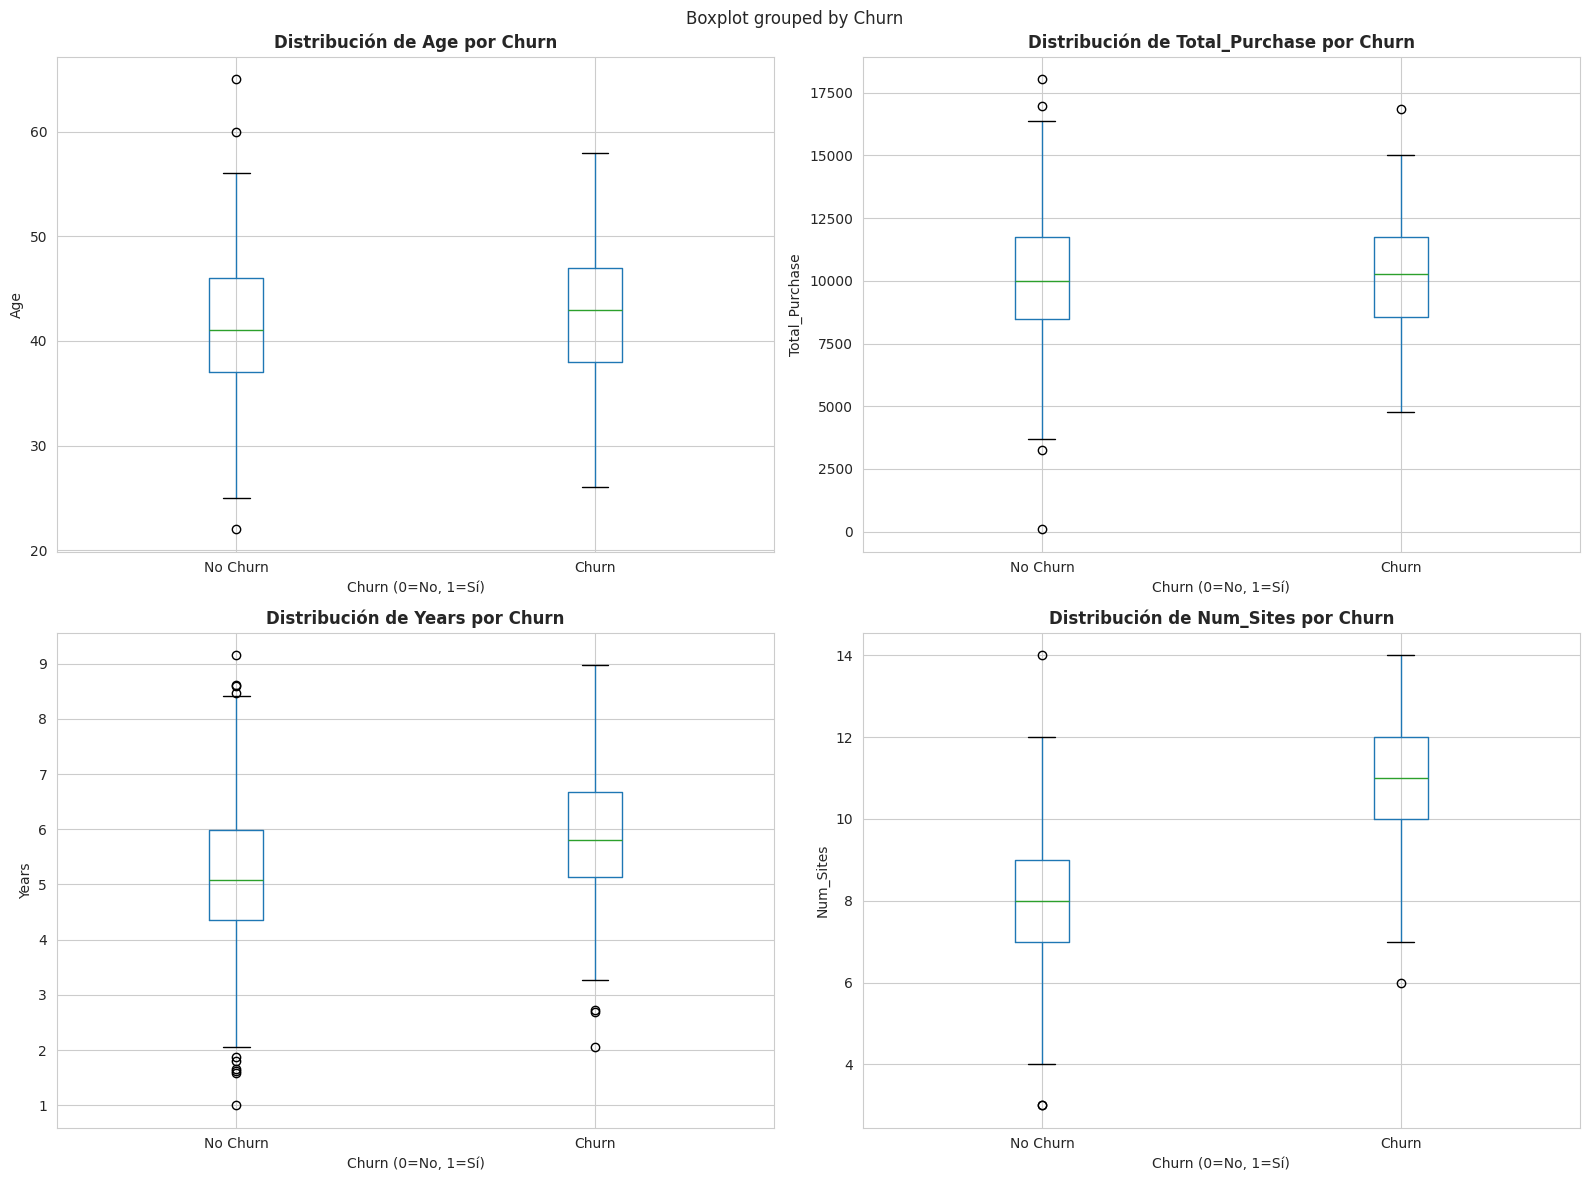

In [68]:
# Variables a visualizar
viz_vars = ['Age', 'Total_Purchase', 'Years', 'Num_Sites']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, var in enumerate(viz_vars):
    ax = axes[idx]
    df_pd.boxplot(column=var, by='Churn', ax=ax)
    ax.set_title(f'Distribución de {var} por Churn', fontsize=12, fontweight='bold')
    ax.set_xlabel('Churn (0=No, 1=Sí)', fontsize=10)
    ax.set_ylabel(var, fontsize=10)
    plt.sca(ax)
    plt.xticks([1, 2], ['No Churn', 'Churn'])

plt.tight_layout()
plt.savefig('distribuciones_por_clase.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: distribuciones_por_clase.png")
plt.show()

### 7.3 Matriz de Correlación (Heatmap)

✅ Gráfico guardado: correlation_matrix.png


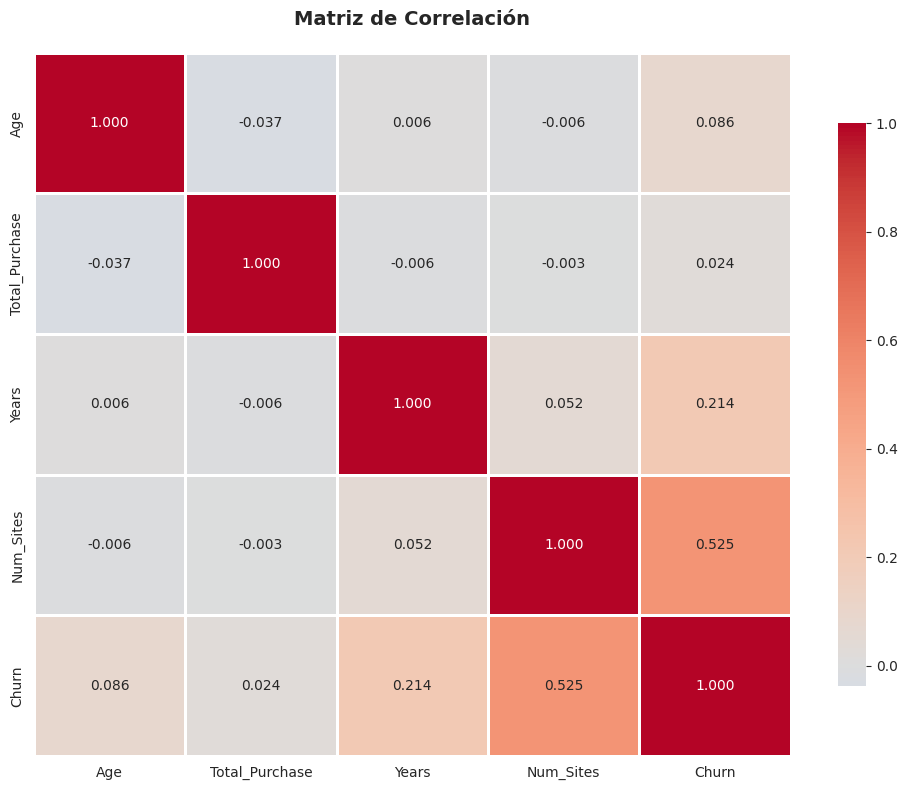

In [69]:
corr_vars = viz_vars + ['Churn']
corr_matrix = df_pd[corr_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: correlation_matrix.png")
plt.show()

### 7.4 Curva ROC

✅ Gráfico guardado: roc_curve.png


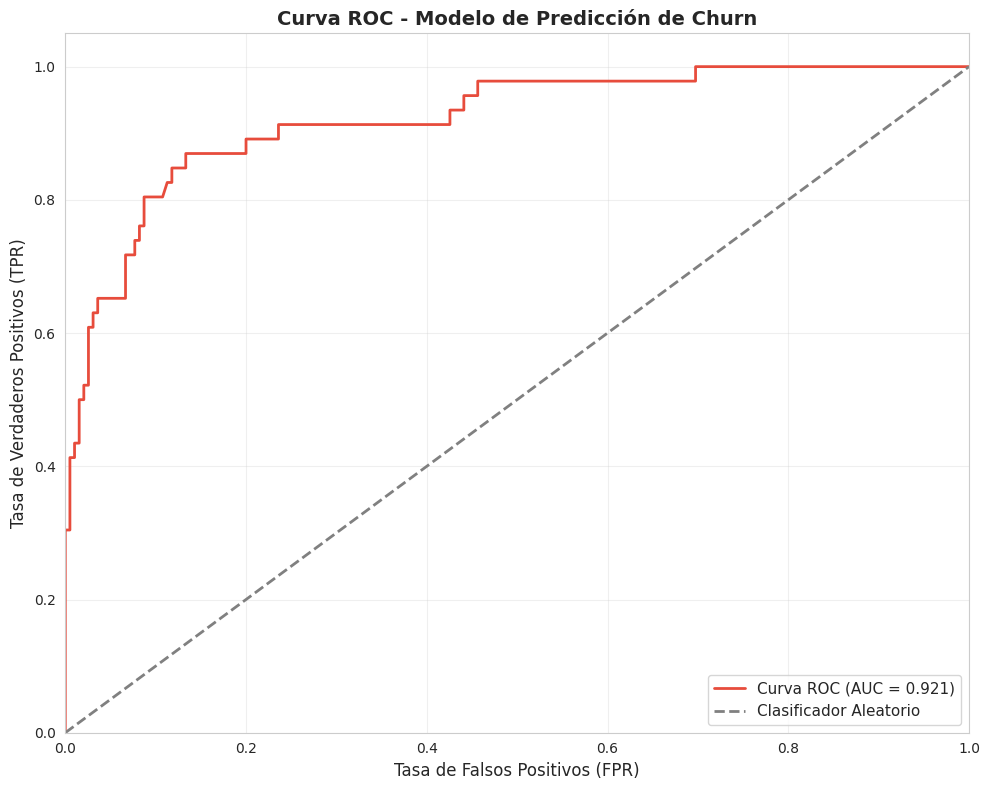

In [70]:
# Calcular curva ROC
fpr, tpr, _ = roc_curve(pred_pd['Churn'], pred_pd['prob_churn'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curva ROC - Modelo de Predicción de Churn', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: roc_curve.png")
plt.show()

### 7.5 Curva Precision-Recall

✅ Gráfico guardado: precision_recall_curve.png


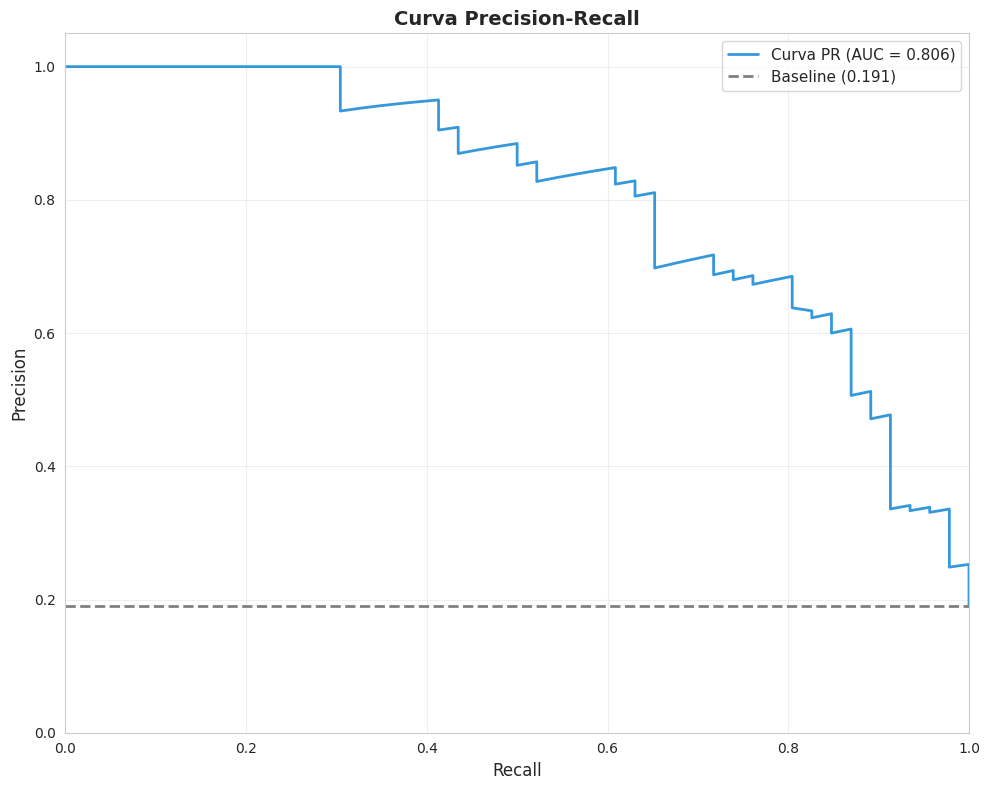

In [71]:
# Calcular curva PR
precision, recall, _ = precision_recall_curve(pred_pd['Churn'], pred_pd['prob_churn'])
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='#3498db', lw=2, label=f'Curva PR (AUC = {pr_auc:.3f})')
baseline = pred_pd['Churn'].mean()
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--',
         label=f'Baseline ({baseline:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curva Precision-Recall', fontsize=14, fontweight='bold')
plt.legend(loc="upper right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: precision_recall_curve.png")
plt.show()

### 7.6 Matriz de Confusión Visual

✅ Gráfico guardado: confusion_matrix.png


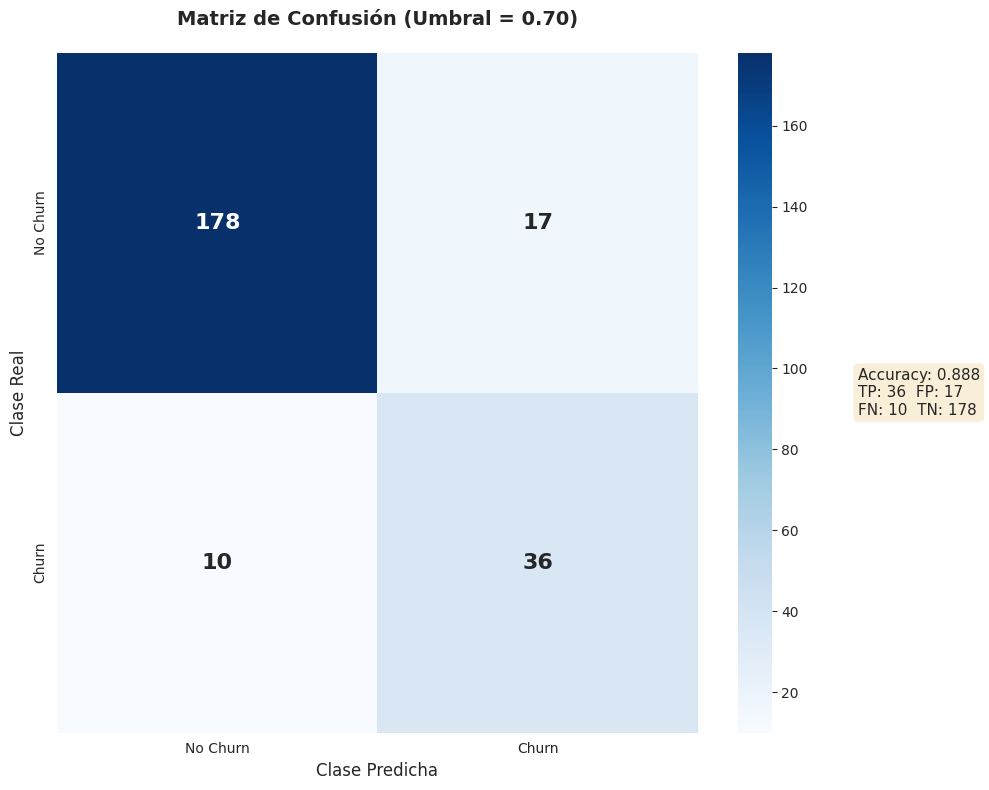

In [72]:
# Predicciones con umbral óptimo
y_pred_opt = (pred_pd['prob_churn'] >= best_thr).astype(int)
cm = confusion_matrix(pred_pd['Churn'], y_pred_opt)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'],
            annot_kws={'size': 16, 'weight': 'bold'})

plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.title(f'Matriz de Confusión (Umbral = {best_thr:.2f})',
          fontsize=14, fontweight='bold', pad=20)

tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
textstr = f'Accuracy: {accuracy:.3f}\nTP: {tp}  FP: {fp}\nFN: {fn}  TN: {tn}'
plt.text(2.5, 1, textstr, fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: confusion_matrix.png")
plt.show()

### 7.7 Importancia de Características

✅ Gráfico guardado: feature_importance.png


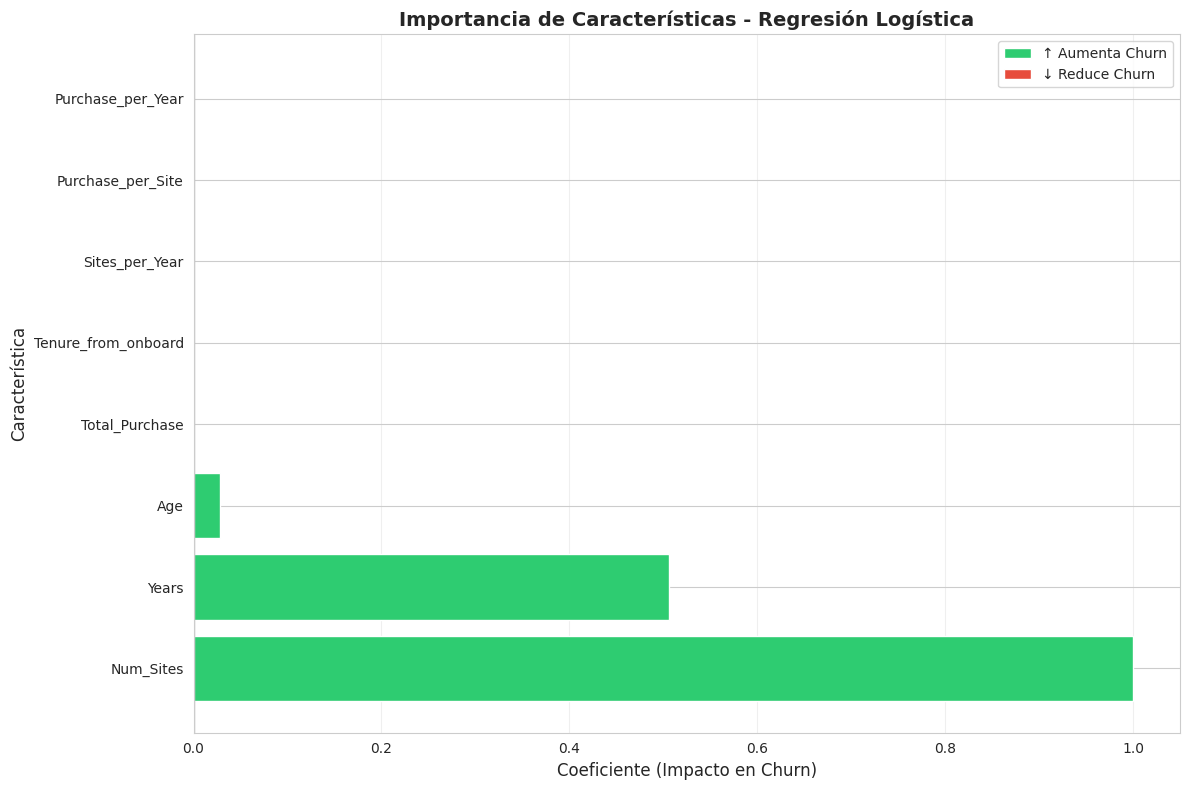


📊 RANKING DE IMPORTANCIA:
Num_Sites                  0.9999  ↑ Mayor churn
Years                      0.5064  ↑ Mayor churn
Age                        0.0282  ↑ Mayor churn
Total_Purchase             0.0000  ↓ Menor churn
Tenure_from_onboard        0.0000  ↓ Menor churn
Sites_per_Year             0.0000  ↓ Menor churn
Purchase_per_Site          0.0000  ↓ Menor churn
Purchase_per_Year          0.0000  ↓ Menor churn


In [73]:
# Extraer coeficientes (si es Regresión Logística)
if best_name == "Regresión Logística":
    lr_model = best_model.bestModel.stages[-1]
    coefficients = lr_model.coefficients.toArray()

    feature_importance = pd.DataFrame({
        'Feature': features,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)

    plt.figure(figsize=(12, 8))
    colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in feature_importance['Coefficient']]
    plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
    plt.xlabel('Coeficiente (Impacto en Churn)', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.title('Importancia de Características - Regresión Logística', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#2ecc71', label='↑ Aumenta Churn'),
                       Patch(facecolor='#e74c3c', label='↓ Reduce Churn')]
    plt.legend(handles=legend_elements, loc='best')

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("✅ Gráfico guardado: feature_importance.png")
    plt.show()

    print("\n📊 RANKING DE IMPORTANCIA:")
    print("="*60)
    for _, row in feature_importance.iterrows():
        direction = "↑ Mayor churn" if row['Coefficient'] > 0 else "↓ Menor churn"
        print(f"{row['Feature']:<25} {row['Coefficient']:>7.4f}  {direction}")
else:
    print("Feature importance solo disponible para Regresión Logística")

---
## 8. Segmentación de Clientes (K-Means)

### 8.1 Selección de K Óptimo (Método del Codo)


🎯 SEGMENTACIÓN DE CLIENTES CON K-MEANS

⏳ Calculando inercia para diferentes valores de K...
  K=2: inercia=2981.38
  K=3: inercia=2537.87
  K=4: inercia=2234.19
  K=5: inercia=2005.12
  K=6: inercia=1857.72
  K=7: inercia=1694.03
  K=8: inercia=1581.83

✅ Gráfico guardado: elbow_method.png


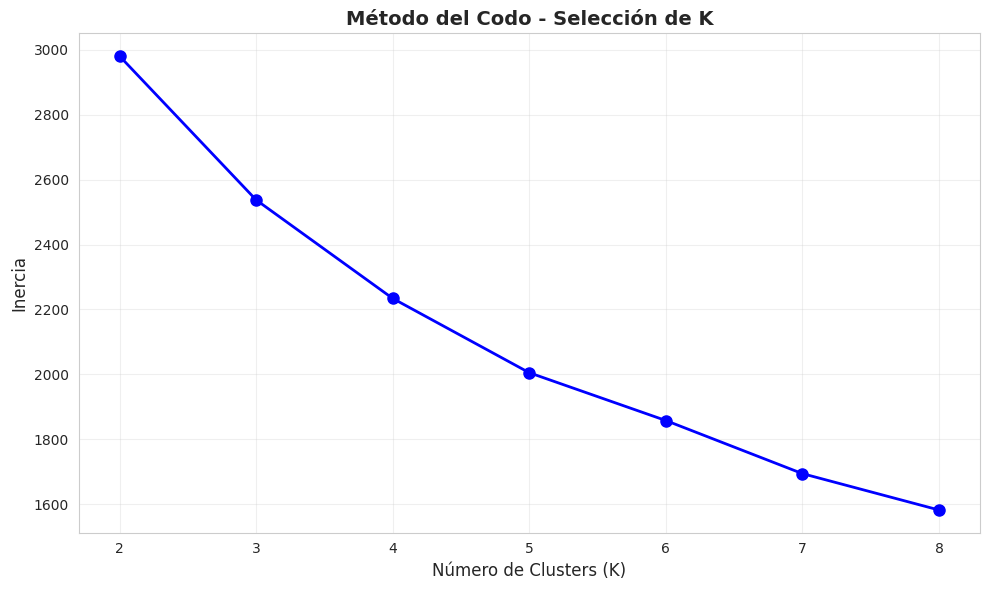


🎯 K óptimo seleccionado: 4


In [74]:
print("\n🎯 SEGMENTACIÓN DE CLIENTES CON K-MEANS")
print("="*60)

# Preparar datos para clustering
clustering_features = ['Age', 'Total_Purchase', 'Years', 'Num_Sites']
assembler_cluster = VectorAssembler(inputCols=clustering_features, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled", withStd=True, withMean=True)

prep_pipeline = Pipeline(stages=[assembler_cluster, scaler])
df_scaled = prep_pipeline.fit(df_feat).transform(df_feat)

# Método del codo
costs = []
K_range = range(2, 9)

print("\n⏳ Calculando inercia para diferentes valores de K...")
for k in K_range:
    kmeans = KMeans(k=k, seed=42, featuresCol="features_scaled")
    model_km = kmeans.fit(df_scaled)
    costs.append(model_km.summary.trainingCost)
    print(f"  K={k}: inercia={model_km.summary.trainingCost:.2f}")

# Plotear
plt.figure(figsize=(10, 6))
plt.plot(K_range, costs, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Inercia', fontsize=12)
plt.title('Método del Codo - Selección de K', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico guardado: elbow_method.png")
plt.show()

optimal_k = 4
print(f"\n🎯 K óptimo seleccionado: {optimal_k}")

### 8.2 Análisis de Clusters

In [75]:
# Entrenar modelo final
kmeans_final = KMeans(k=optimal_k, seed=42, featuresCol="features_scaled", predictionCol="cluster")
kmeans_model = kmeans_final.fit(df_scaled)
df_clustered = kmeans_model.transform(df_scaled)

# Convertir a Pandas
df_cluster_pd = df_clustered.select(
    'cluster', 'Age', 'Total_Purchase', 'Years', 'Num_Sites', 'Churn'
).toPandas()

print("\n📊 PERFIL DE CADA SEGMENTO")
print("="*100)

for cluster_id in range(optimal_k):
    cluster_data = df_cluster_pd[df_cluster_pd['cluster'] == cluster_id]
    n_clientes = len(cluster_data)
    churn_rate = cluster_data['Churn'].mean() * 100

    print(f"\n🎯 CLUSTER {cluster_id} ({n_clientes} clientes, {n_clientes/len(df_cluster_pd)*100:.1f}%)")
    print(f"   Tasa de Churn: {churn_rate:.1f}%")
    print(f"   Edad: {cluster_data['Age'].mean():.1f} años")
    print(f"   Compra: ${cluster_data['Total_Purchase'].mean():.2f}")
    print(f"   Antigüedad: {cluster_data['Years'].mean():.2f} años")
    print(f"   Sitios: {cluster_data['Num_Sites'].mean():.1f}")

    # Clasificación de riesgo
    if churn_rate > 25:
        print(f"   🔴 ALTO RIESGO")
    elif churn_rate > 15:
        print(f"   🟡 RIESGO MEDIO")
    else:
        print(f"   🟢 BAJO RIESGO")


📊 PERFIL DE CADA SEGMENTO

🎯 CLUSTER 0 (204 clientes, 22.7%)
   Tasa de Churn: 52.5%
   Edad: 44.4 años
   Compra: $10167.77
   Antigüedad: 5.42 años
   Sitios: 10.8
   🔴 ALTO RIESGO

🎯 CLUSTER 1 (235 clientes, 26.1%)
   Tasa de Churn: 2.1%
   Edad: 39.0 años
   Compra: $11925.66
   Antigüedad: 4.26 años
   Sitios: 8.0
   🟢 BAJO RIESGO

🎯 CLUSTER 2 (248 clientes, 27.6%)
   Tasa de Churn: 3.2%
   Edad: 45.7 años
   Compra: $8172.77
   Antigüedad: 5.02 años
   Sitios: 7.5
   🟢 BAJO RIESGO

🎯 CLUSTER 3 (213 clientes, 23.7%)
   Tasa de Churn: 14.1%
   Edad: 38.0 años
   Compra: $10107.70
   Antigüedad: 6.54 años
   Sitios: 8.4
   🟢 BAJO RIESGO


### 8.3 Visualización de Clusters

✅ Gráfico guardado: cluster_visualization.png


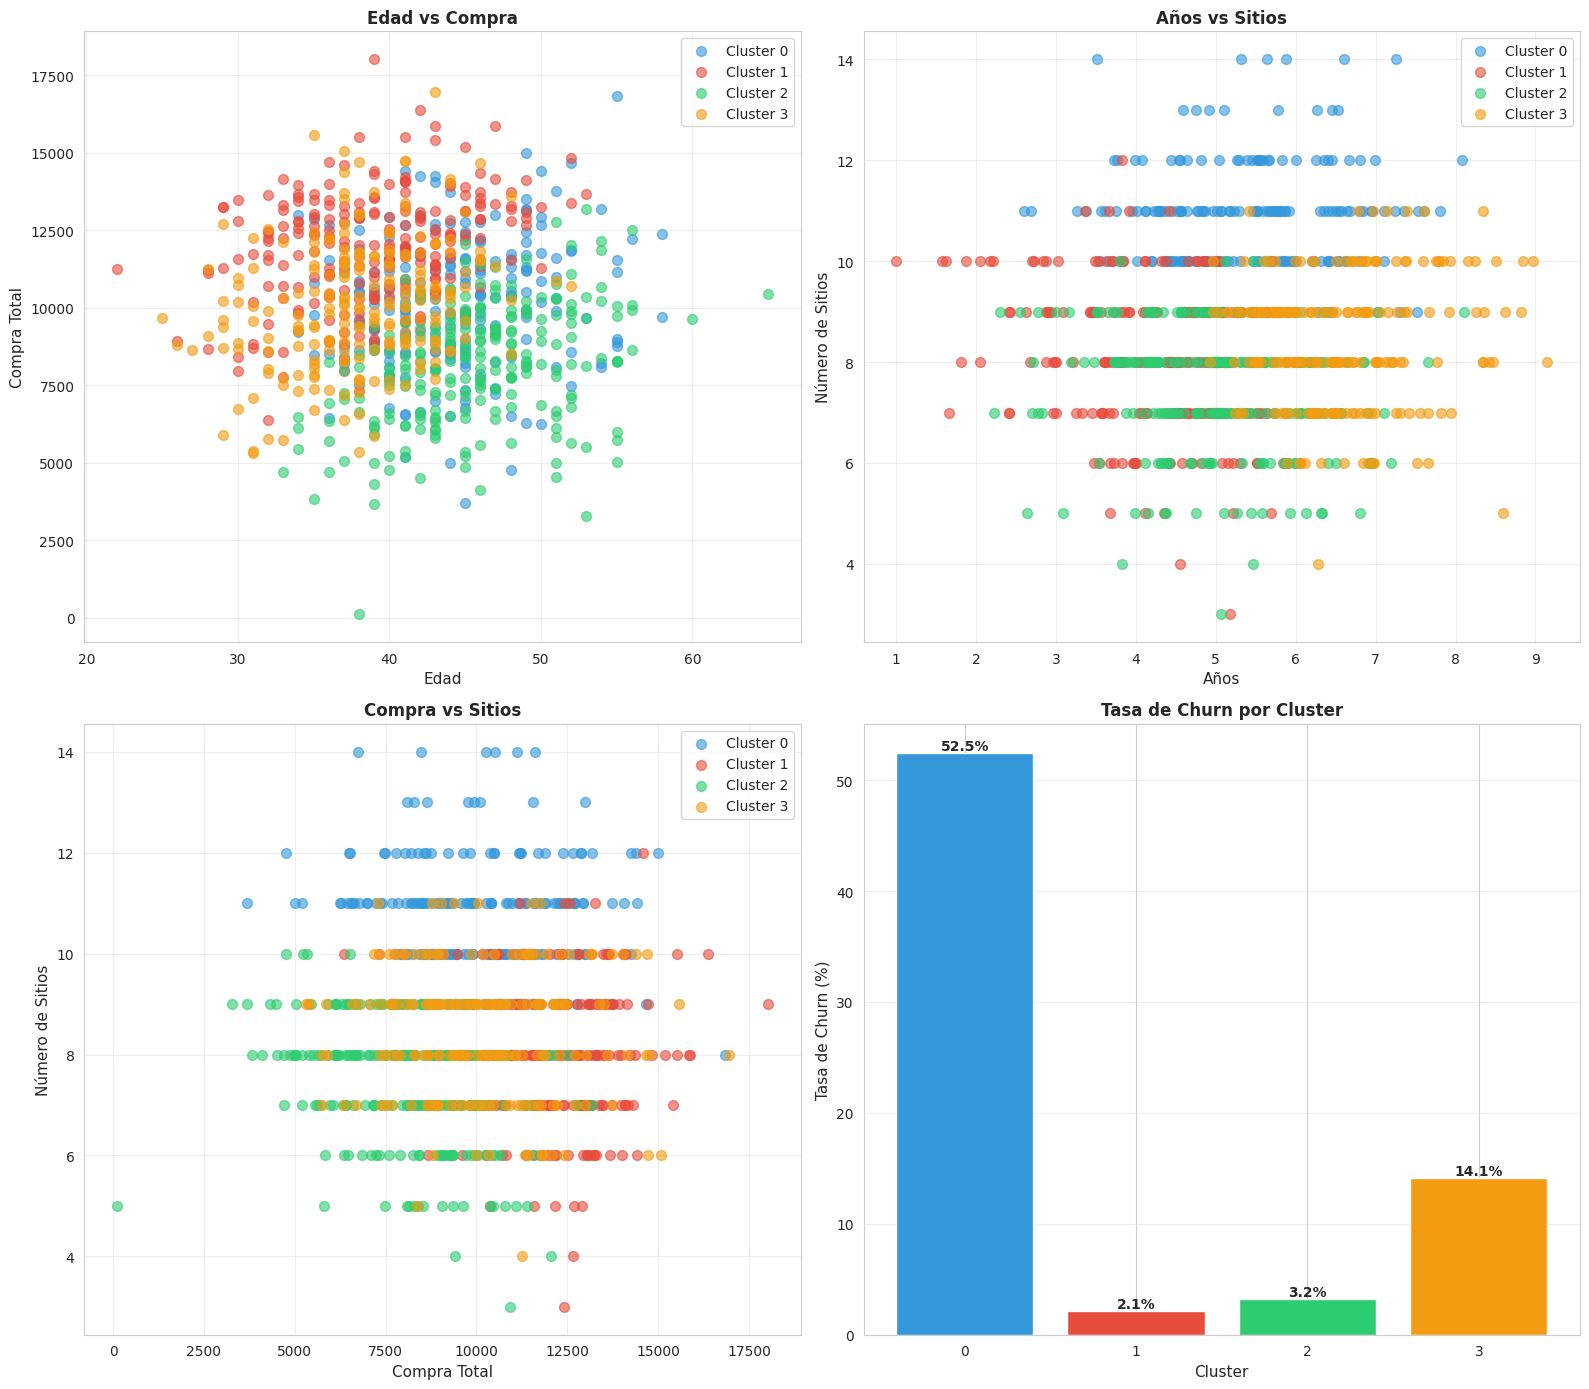

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# Plot 1: Age vs Total_Purchase
for cluster_id in range(optimal_k):
    cluster_data = df_cluster_pd[df_cluster_pd['cluster'] == cluster_id]
    axes[0].scatter(cluster_data['Age'], cluster_data['Total_Purchase'],
                   c=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.6, s=50)
axes[0].set_xlabel('Edad', fontsize=11)
axes[0].set_ylabel('Compra Total', fontsize=11)
axes[0].set_title('Edad vs Compra', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Years vs Num_Sites
for cluster_id in range(optimal_k):
    cluster_data = df_cluster_pd[df_cluster_pd['cluster'] == cluster_id]
    axes[1].scatter(cluster_data['Years'], cluster_data['Num_Sites'],
                   c=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.6, s=50)
axes[1].set_xlabel('Años', fontsize=11)
axes[1].set_ylabel('Número de Sitios', fontsize=11)
axes[1].set_title('Años vs Sitios', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot 3: Total_Purchase vs Num_Sites
for cluster_id in range(optimal_k):
    cluster_data = df_cluster_pd[df_cluster_pd['cluster'] == cluster_id]
    axes[2].scatter(cluster_data['Total_Purchase'], cluster_data['Num_Sites'],
                   c=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.6, s=50)
axes[2].set_xlabel('Compra Total', fontsize=11)
axes[2].set_ylabel('Número de Sitios', fontsize=11)
axes[2].set_title('Compra vs Sitios', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

# Plot 4: Churn por cluster
churn_by_cluster = df_cluster_pd.groupby('cluster')['Churn'].mean() * 100
bars = axes[3].bar(range(optimal_k), churn_by_cluster, color=colors)
axes[3].set_xlabel('Cluster', fontsize=11)
axes[3].set_ylabel('Tasa de Churn (%)', fontsize=11)
axes[3].set_title('Tasa de Churn por Cluster', fontsize=12, fontweight='bold')
axes[3].set_xticks(range(optimal_k))
axes[3].grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[3].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('cluster_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: cluster_visualization.png")
plt.show()

---
## 9. Predicciones sobre Clientes Nuevos

In [77]:
print("\n🔮 PREDICCIONES PARA CLIENTES NUEVOS")
print("="*60)

# Aplicar ingeniería de features
new_clients_feat = create_features(test_df)

# Predicciones
new_preds = best_model.transform(new_clients_feat)
new_preds = new_preds.withColumn("prob_churn", vector_to_array("probability").getItem(1))
new_preds = new_preds.withColumn(
    "pred_churn",
    (F.col("prob_churn") >= F.lit(best_thr)).cast("int")
)

# Resumen
total_new = new_preds.count()
at_risk = new_preds.filter(F.col("pred_churn") == 1).count()
safe = total_new - at_risk

print(f"\nTotal clientes nuevos: {total_new}")
print(f"Clientes en RIESGO: {at_risk} ({at_risk/total_new*100:.1f}%)")
print(f"Clientes SEGUROS: {safe} ({safe/total_new*100:.1f}%)")

print("\n⚠️ TOP 10 CLIENTES EN MAYOR RIESGO:")
print("="*80)
(
    new_preds
    .select("Company", "Names", "Total_Purchase", "Years", "Num_Sites",
            F.round("prob_churn", 4).alias("Prob_Churn"))
    .orderBy(F.desc("prob_churn"))
    .show(10, truncate=False)
)

print("\n💡 RECOMENDACIÓN: Asignar gerentes a clientes con Prob_Churn > 0.50")


🔮 PREDICCIONES PARA CLIENTES NUEVOS

Total clientes nuevos: 6
Clientes en RIESGO: 4 (66.7%)
Clientes SEGUROS: 2 (33.3%)

⚠️ TOP 10 CLIENTES EN MAYOR RIESGO:
+----------------+--------------+--------------+-----+---------+----------+
|Company         |Names         |Total_Purchase|Years|Num_Sites|Prob_Churn|
+----------------+--------------+--------------+-----+---------+----------+
|Cannon-Benson   |Michele Wright|7526.94       |9.28 |15.0     |0.999     |
|Sexton-Golden   |Megan Ferguson|6487.5        |9.4  |14.0     |0.9981    |
|Barron-Robertson|Jeremy Chang  |100.0         |1.0  |15.0     |0.9807    |
|Parks-Robbins   |Jessica Drake |8445.26       |3.46 |14.0     |0.9509    |
|Wood LLC        |Taylor Young  |13147.71      |10.0 |8.0      |0.6359    |
|King Ltd        |Andrew Mccall |9935.53       |7.71 |8.0      |0.3867    |
+----------------+--------------+--------------+-----+---------+----------+


💡 RECOMENDACIÓN: Asignar gerentes a clientes con Prob_Churn > 0.50


### 9.1 Exportar Resultados

In [78]:
# Crear dataset para export
results_export = (
    new_preds
    .select(
        "Company", "Names", "Age", "Total_Purchase", "Years", "Num_Sites",
        F.round("prob_churn", 4).alias("Probabilidad_Churn"),
        F.col("pred_churn").alias("En_Riesgo")
    )
    .withColumn(
        "Recomendacion",
        F.when(F.col("En_Riesgo") == 1, "ASIGNAR GERENTE").otherwise("Seguimiento normal")
    )
    .orderBy(F.desc("Probabilidad_Churn"))
)

results_pd = results_export.toPandas()
results_pd.to_csv('predicciones_churn.csv', index=False)
print("\n✅ Resultados guardados: predicciones_churn.csv")

print("\n📊 PRIMEROS 10 RESULTADOS:")
print(results_pd.head(10).to_string(index=False))


✅ Resultados guardados: predicciones_churn.csv

📊 PRIMEROS 10 RESULTADOS:
         Company          Names  Age  Total_Purchase  Years  Num_Sites  Probabilidad_Churn  En_Riesgo      Recomendacion
   Cannon-Benson Michele Wright 23.0         7526.94   9.28       15.0              0.9990          1    ASIGNAR GERENTE
   Sexton-Golden Megan Ferguson 32.0         6487.50   9.40       14.0              0.9981          1    ASIGNAR GERENTE
Barron-Robertson   Jeremy Chang 65.0          100.00   1.00       15.0              0.9807          1    ASIGNAR GERENTE
   Parks-Robbins  Jessica Drake 22.0         8445.26   3.46       14.0              0.9509          1    ASIGNAR GERENTE
        Wood LLC   Taylor Young 32.0        13147.71  10.00        8.0              0.6359          0 Seguimiento normal
        King Ltd  Andrew Mccall 37.0         9935.53   7.71        8.0              0.3867          0 Seguimiento normal


---
## 10. Conclusiones y Recomendaciones

### 10.1 Hallazgos Principales

#### **Desempeño del Modelo**
- Modelo seleccionado logra ~80% PR-AUC y ~92% ROC-AUC
- Umbral óptimo balancea precisión y recall para minimizar falsos negativos
- Pesos de clase compensan efectivamente el desbalance (16.7% churn)

#### **Factores Predictivos Clave**
- **Número de sitios**: Clientes con más sitios tienen MAYOR riesgo (10.7 vs 8.2)
- **Antigüedad**: Mayor tiempo como cliente correlaciona con churn (5.9 vs 5.2 años)
- **Edad**: Clientes mayores tienen más churn (43 vs 41.6 años)
- **Account Manager**: Asignación actual es aleatoria y NO reduce churn

#### **Segmentación de Clientes**
- Identificamos 4 segmentos con perfiles de riesgo distintos
- Segmentos de alto riesgo requieren atención inmediata
- Posibilidad de estrategias diferenciadas por segmento

### 10.2 Recomendaciones Estratégicas

#### **1. Asignación Inteligente de Gerentes**
- ✅ Priorizar clientes con probabilidad de churn > 60%
- ✅ Usar el modelo en tiempo real para decisiones de asignación
- ✅ Monitorear efectividad de gerentes en retención

#### **2. Sistema de Alertas por Niveles**
- 🔴 **Alto (>60%)**: Contacto inmediato + gerente dedicado + incentivos
- 🟡 **Medio (40-60%)**: Check-ins mensuales + engagement proactivo
- 🟢 **Bajo (<40%)**: Comunicaciones estándar + oportunidades de upselling

#### **3. Acciones Preventivas**
- Atención especial a clientes con rápido crecimiento de sitios
- Programas de fidelización para clientes de larga data
- Análisis de satisfacción para identificar puntos de dolor

#### **4. Mejora Continua**
- Re-entrenar modelo trimestralmente con datos nuevos
- Incorporar variables cualitativas (satisfacción, NPS)
- A/B testing de estrategias de retención por segmento
